## Non-local Sparse Models for Image Restorations

Following is an implementation of the image restoration approaches proposed by Mairal et. al. in 2009.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub

# Download latest version of the dataset used in the paper
path = kagglehub.dataset_download("zaraks/pascal-voc-2007")

print("Path to dataset files:", path)

/Users/silvanusbordignon/Documents/Università/4° anno/Primo semestre/Signal, Image and Video/siv/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/silvanusbordignon/.cache/kagglehub/datasets/zaraks/pascal-voc-2007/versions/1


In [3]:
SEED = 42           # 42 is the seed used by us for the experiments
PATCH_SIZE = 8      # Pixel side size of the patches
EXAMPLE_SIZE = 256  # Pixel side size of the examples

In [4]:
import concurrent.futures
import os
import random
import numpy as np

# We use PIL due to problems with cv2 for opening images due to unicode present in path
from PIL import Image 


import os
from PIL import Image # we use PIL due to problems with cv2 for opening images due to unicode present in path
import random
import numpy

def generate_patch(path, height, width, verbose=False, seed=None):
    """
    Generate a height x width greyscale patch from a random
    image sampled from the ones in the given path

    Args:
        path (str): location of image (.png or .jpg) dataset
        height (int): height of patch, must be positive
        width (int): width of patch, must be positive
        verbose (bool): whether to print how many images can be used to generate patches
        seed (int): the seed to be used for the random number generator

    Returns:
        Image: generated patch, or None if height or width are invalid
    """
    
    if (height<1 or width<1):
        print("invalid height or width, they must be positive")
        return None
    
    # Sets seed
    random.seed(seed)
    
    # List all image files in the directory, sorted to make it deterministic
    image_files = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')])

    # Filter images based on size
    valid_images = []
    for image_file in image_files:
        with Image.open(image_file) as img:
            if img.size[0] >= width and img.size[1] >= height:
                valid_images.append(image_file)

    if len(valid_images)<1 :
        print(f"No valid images found")
        return None
    
    if verbose:
        print(f"Found {len(valid_images)} valid images")

    # Select a random image from the valid images
    random_image = random.choice(valid_images)
 
     # Open the selected image
    with Image.open(random_image) as img:
        # Convert image to greyscale
        img = img.convert("L")
        # Generate a random patch
        x = random.randint(0, img.size[0] - width)
        y = random.randint(0, img.size[1] - height)
        patch = img.crop((x, y, x + width, y + height))
    
    
    return patch


# Function to generate multiple patches within a worker thread
def extract_patches(worker_id, images_subset, num_patches, height, width, seed):
    try:
        # Unique seed for each worker
        random.seed(seed + worker_id)  
        np.random.seed(seed + worker_id)

        # Initialize an array to store patches
        patches = np.empty((num_patches,height*width), dtype=np.uint8)
        
        for i in range(num_patches):
            # Select a random image from the valid images
            random_image = random.choice(images_subset)
            with Image.open(random_image) as img:
                # Convert to grayscale
                img = img.convert("L")  
                # Generate a random patch
                x = random.randint(0, img.size[0] - width)
                y = random.randint(0, img.size[1] - height)
                patch = img.crop((x, y, x + width, y + height))
                patches[i]=np.array(patch).flatten()

        return patches

    except Exception as e:
        # Return an empty array instead of crashing
        print(f"Worker {worker_id} failed: {e}")
        return np.empty((0, height * width), dtype=np.uint8)


def generate_patches_concurrent(path, height, width, n, verbose=False, seed=None, num_workers=12):
    """
    Generate n height x width greyscale patches from random
    images sampled from the ones in the given path in a concurrent manner

    Args:
        path (str): location of image (.png or .jpg) dataset
        height (int): height of patch, must be positive
        width (int): width of patch, must be positive
        n (int): number of patches you want to generate
        verbose (bool): whether to print how many images can be used to generate patches
        seed (int): the seed to be used for the random number generator
        num_workers (int): number of threads you want to use

    Returns:
        NDarray[NDarray]: numpy array of generated patches in the format needed by 
                        MiniBatchDictionaryLearning, or None if height or width are invalid
    """

    if height < 1 or width < 1:
        print("Invalid height or width, they must be positive")
        return None

    # Sets seed
    random.seed(seed)

    # List all image files in the directory, sorted to make it deterministic
    image_files = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')])

    # Filter images based on size
    valid_images = [img for img in image_files if Image.open(img).size[0] >= width and Image.open(img).size[1] >= height]

    if len(valid_images) < 1:
        print(f"No valid images found")
        return None

    if verbose:
        print(f"Found {len(valid_images)} valid images")

    # Divide images fairly among workers
    image_chunks = np.array_split(valid_images, num_workers)
    num_patches_per_worker = n // num_workers

    # Initialize empty array to store patches
    patches = np.empty((n, height * width), dtype=np.uint8)

    # Run parallel execution with ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {
            executor.submit(extract_patches, i, image_chunks[i], num_patches_per_worker, 
                            height, width, seed): i
            for i in range(num_workers)
        }

        # Collect results and merge into final patches array
        start_idx = 0
        for future in concurrent.futures.as_completed(futures):
            worker_patches = future.result()

            # Ensure worker returned valid patches before assigning
            if worker_patches.shape[0] > 0:
                patches[start_idx:start_idx + worker_patches.shape[0]] = worker_patches
                start_idx += worker_patches.shape[0]

    return patches


In [5]:
import cv2

def add_gaussian_noise(image, mean=0, std=0.5, seed=None):
    """
    Add Gaussian noise to an image.
    
    Args:
        image (NDarray): the input image in the format cv2 uses
        mean (float): the mean of the Gaussian noise
        std (float): the standard deviation of the Gaussian noise
        seed (int): the seed to be used for the random number generator 
    
    Returns:
        NDarray: the image with the added Gaussian noise
    """
    # Sets the seed
    np.random.seed(seed)

    # Generate Gaussian noise
    gaussian_noise = np.random.normal(mean, std, image.shape).astype('uint8')
    
    # Add the Gaussian noise to the image
    noisy_image = cv2.add(image, gaussian_noise)
    
    return noisy_image

In [6]:
# Extract patches centered on each pixel

def extract_all_centered_patches(image, height, width):
    """
    Extracts a patch centered at each pixel in the image.
    
    Args:
        image (NDarray): Input image as a 2D array.
        height (int): Height of the patch.
        width (int): Width of the patch.
    
    Returns:
        NDarray[NDarray[NDarray]]: Array containing all the extracted patches
    """
    
    H, W = image.shape
    
    # Calculate half sizes
    h_half = height // 2
    w_half = width // 2
    
    # Pad the image to handle border pixels
    padded_img = cv2.copyMakeBorder(image, h_half, h_half, w_half, w_half, 
                                    borderType=cv2.BORDER_REFLECT) 
    # Border reflect was used due to it seemingly being common practice
    
    # Initialize an array to hold the patches
    patches = numpy.empty((H*W, height, width), dtype=image.dtype)
    
    # Loop over each pixel position in the original image
    for i in range(H):
        for j in range(W):
            patch = padded_img[i: i + height, 
                               j: j + width]
            patches[i*W+j] = patch
    
    return patches

In [7]:
import time

def process_patch_batch(start_idx, end_idx, patches, patches_vec, xi, neighbor_indices):
    """
    Process a batch of patches to find similar patches within the search window.
    """
    results = {}

    for i in range(start_idx, end_idx):
        candidate_indices = neighbor_indices[i]
        
        # Compute squared Euclidean distances in a vectorized manner
        patch_current = patches_vec[i]
        candidates = patches_vec[candidate_indices]
        dists = np.sum((candidates - patch_current) ** 2, axis=1)

        # Select patches within the threshold
        results[i] = patches[candidate_indices[dists <= xi]]

    return results


def precompute_neighbor_indices(height, width, w):
    """
    Precompute the indices of all neighboring patches within the window for each pixel.
    """
    n = height * width
    w_half = w // 2
    row_indices = np.arange(height).repeat(width)
    col_indices = np.tile(np.arange(width), height)
    neighbor_indices = []

    for i in range(n):
        row, col = row_indices[i], col_indices[i]

        # Define window boundaries
        r_min, r_max = max(0, row - w_half), min(height - 1, row + w_half)
        c_min, c_max = max(0, col - w_half), min(width - 1, col + w_half)

        # Generate candidate indices within the window
        r_grid, c_grid = np.meshgrid(np.arange(r_min, r_max + 1), np.arange(c_min, c_max + 1),
                                         indexing='ij')
        neighbor_indices.append((r_grid * width + c_grid).ravel())

    return np.array(neighbor_indices, dtype=object)


def block_matching_similar_patches_concurrent(patches, height, width, xi, w, num_workers=12):
    """
    Given an array of patches extracted from an image and a threshold xi,
    performs block matching within a window of size w x w for each patch.
    
    Args:
        patches (NDarray): Array of extracted patches from extract_all_centered_patches()
        height (int): Height of the original image.
        width (int): Width of the original image.
        xi (float): Threshold for the squared Euclidean distance.
        w (int): Size of the search window (w x w).
        num_workers (int): number of threads you want to use
        
    Returns:
        similar_patches (list): A list containing for every pixel in the original imagean array 
                                containing the patches similar to the patch centered on that pixel.
    """
    n, _, _ = patches.shape
    patches_vec = patches.reshape(n, -1)

    # Precompute neighbor indices for all patches
    neighbor_indices = precompute_neighbor_indices(height, width, w)

    # Initialize list to store results
    similar_patches = [None] * n

    # Divide patches into chunks
    chunk_size = max(1, n // num_workers)
    chunks = [(i, min(i + chunk_size, n)) for i in range(0, n, chunk_size)]

    # Use ThreadPoolExecutor to process batches in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {
            executor.submit(process_patch_batch, start, end, patches, patches_vec, 
                            xi, neighbor_indices): (start, end)
            for start, end in chunks
        }

        # Collect results
        for future in concurrent.futures.as_completed(futures):
            batch_results = future.result()
            for i, result in batch_results.items():
                similar_patches[i] = result

    return similar_patches

In [8]:
import matplotlib.pyplot as plt
import math

def display_patch_sets(similar_patches,pixel_index, height, width, cmap='gray'):
    """
    Display all patches from one similar patch sets.
    
    Args:
        similar_patches (list or dict): The output from block_matching_similar_patches.
        pixel_index (int): Index of patch set you want to display.
        height (int): The patch height, must be positive.
        width (int): The patch width, must be positive.
        cmap (str): Color map to use for display, default is 'gray'.
    """
     
    # Prepare the patches
    patches = similar_patches[pixel_index]
    num_patches = patches.shape[0]
    # Determine grid size for the set
    cols = min(10, num_patches)
    rows = math.ceil(num_patches / cols)
    # Prepare the figure
    plt.figure(figsize=(cols * 1.5, rows * 1.5))
    plt.suptitle(f"Similar patches for pixel index {pixel_index}", fontsize=16)
    
    # Display one by one the patches
    for i in range(num_patches):
        plt.subplot(rows, cols, i + 1)
        patch = patches[i].reshape(height, width)
        plt.imshow(patch, cmap=cmap,vmin=0,vmax=255)
        plt.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [9]:
from sklearn.linear_model import MultiTaskLasso


def optimize_equation_8_batch(Y, D, S, epsilon=1e-3):
    """
    Optimized batch version of Equation (8).

    Parameters:
    - Y: np.ndarray of shape (l, P, P), image patches.
    - D: np.ndarray of shape (k, P*P), dictionary.
    - S: list of np.ndarray, similar patches.
    - epsilon: float, error tolerance.

    Returns:
    - A: np.ndarray of shape (k, l), the sparse coefficient matrix.
    """
    l, P, _ = Y.shape
    k = D.shape[0]
    D_matrix = D.reshape(k, P * P)

    # Flatten patches
    Y_flat = Y.reshape(l, P * P)

    # Use batch sparse coding solver (e.g., LassoLars)
    from sklearn.linear_model import LassoLars
    lasso = LassoLars(alpha=epsilon)

    A = np.zeros((k, l))
    A = lasso.fit(D_matrix.T, Y_flat.T).coef_.T  # Solve in batch

    return A


def solve_sparse_group_lasso(Y_Si, D_matrix, p, q, epsilon):
    """
    Solves the group sparse coding problem for a set of similar patches.

    Parameters:
    - Y_Si: np.ndarray of shape (N, P*P), flattened patches in the similarity group.
    - D_matrix: np.ndarray of shape (k, P*P), dictionary elements.
    - p, q: Norm parameters, default (1,2) for convex formulation.
    - epsilon: Error tolerance for the constraint.

    Returns:
    - A_Si: np.ndarray of shape (k,), the sparse coefficient vector for the pixel.
    """
    if Y_Si.shape[0] == 0:
        return np.zeros(D_matrix.shape[0])  # Return zero vector if no patches

    # Solve sparse coding using MultiTaskLasso (convex case)
    lasso = MultiTaskLasso(alpha=epsilon, fit_intercept=False)
    A_Si = lasso.fit(D_matrix.T, Y_Si.T).coef_.T  # Fix the inconsistent dimensions

    return A_Si.mean(axis=1)  # Average over similar patches


def optimize_equation_8(Y, D, S, p=1, q=2, epsilon=None):
    """
    Solves the optimization problem in Equation (8) for non-local sparse coding.

    Parameters:
    - Y: np.ndarray of shape (l, P, P), image patches for each pixel.
    - D: sklearn MiniBatchDictionaryLearning object or np.ndarray of shape (k, P*P), dictionary components.
    - S: list of np.ndarrays, where each entry contains a set of similar patches of shape (N, P, P).
    - p, q: Norm parameters, default to (1,2) for the convex case.
    - epsilon: np.ndarray of shape (l,) or None, error tolerance for each patch group.

    Returns:
    - A: np.ndarray of shape (k, l), the sparse coefficient matrix.
    """

    l, P, _ = Y.shape  # Number of pixels and patch size
    k = D.components_.shape[0] if hasattr(D, "components_") else D.shape[0]  # Dictionary size
    D_matrix = D.components_ if hasattr(D, "components_") else D  # Extract dictionary components
    D_matrix = D_matrix.reshape(k, P * P)  # Ensure dictionary is in matrix form

    A = np.zeros((k, l))  # Initialize sparse coefficient matrix

    for i in range(l):
        print("i:", i)
        Si = S[i]  # Get similar patches as a numpy array of shape (N, P, P)
        if Si.shape[0] == 0:
            continue  # Skip if no similar patches

        Y_Si = Si.reshape(Si.shape[0], P * P)  # Flatten patches to (N, P*P)
        epsilon_i = epsilon[i] if epsilon is not None else 1e-3  # Default tolerance

        # Solve the sparse coding problem with joint sparsity
        A[:, i] = solve_sparse_group_lasso(Y_Si, D_matrix, p, q, epsilon_i)

    return A

In [10]:
def reconstruct_image(A, D, S, image_shape, P):
    """
    Reconstructs the original image using Equation (9) from the paper.

    Parameters:
    - A: np.ndarray of shape (k, l), the sparse coefficient matrix.
    - D: np.ndarray of shape (k, P*P), the learned dictionary.
    - S: list of np.ndarrays, each containing similar patches for a given pixel.
    - image_shape: tuple (H, W), the height and width of the original image.
    - P: int, the side length of each patch.

    Returns:
    - x: np.ndarray of shape (H, W), the reconstructed image.
    """
    H, W = image_shape
    l = len(S)  # Number of pixels in the image
    x = np.zeros((H, W))  # Initialize the reconstructed image
    weight = np.zeros((H, W))  # Normalization matrix to account for overlapping patches

    half_P = P // 2  # Half patch size for placement

    for i in range(l):
        Si = S[i]  # Set of similar patches (N, P, P)
        if Si.shape[0] == 0:
            continue  # Skip if no similar patches
        
        # Compute the reconstructed patch from sparse coefficients
        reconstructed_patches = (D.T @ A[:, i]).reshape(P, P)  # Reshape to (P, P)

        # Find pixel location in the original image
        row = i // W  # Row index of the pixel
        col = i % W   # Column index of the pixel

        # Compute valid patch region within the image bounds
        row_start, row_end = max(row - half_P, 0), min(row - half_P + P, H)
        col_start, col_end = max(col - half_P, 0), min(col - half_P + P, W)

        # Crop the patch to fit inside the image if needed
        patch_r_start = max(half_P - row, 0)
        patch_r_end = patch_r_start + (row_end - row_start)
        patch_c_start = max(half_P - col, 0)
        patch_c_end = patch_c_start + (col_end - col_start)

        x[row_start:row_end, col_start:col_end] += reconstructed_patches[patch_r_start:patch_r_end, patch_c_start:patch_c_end]
        weight[row_start:row_end, col_start:col_end] += 1  # Keep track of how many patches contribute to each pixel

    # Normalize by the number of overlapping patches
    weight[weight == 0] = 1  # Avoid division by zero
    x /= weight  # Normalize pixel values

    return x


# Example

In [11]:
from sklearn.decomposition import MiniBatchDictionaryLearning

# Augment the dataset by generating patches of varying size
dataset = generate_patches_concurrent(path + "/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages", PATCH_SIZE, PATCH_SIZE, 10**7, False, seed=SEED)

# Check the shape of the dataset
print(dataset.shape)

# Train the dictionary
model = MiniBatchDictionaryLearning(alpha=1, max_iter=1000, n_jobs=-1, fit_algorithm='lars', batch_size=256, random_state=SEED)
model.fit(dataset)

(10000000, 64)


MiniBatchDictionaryLearning(n_jobs=-1, random_state=42)

In [23]:
# Save the model, since 432m 52.1s of training are hopefully a one-time event
np.save('model.npy', model.components_)

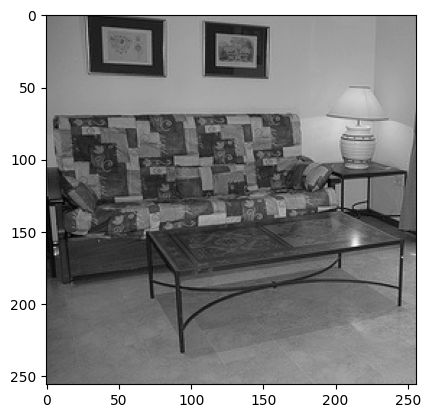

In [12]:
# Let's generate a patch and plot it to check the correctness of the function

patch = generate_patch(path + "/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages", EXAMPLE_SIZE, EXAMPLE_SIZE, seed=SEED)
plt.imshow(patch,"grey")

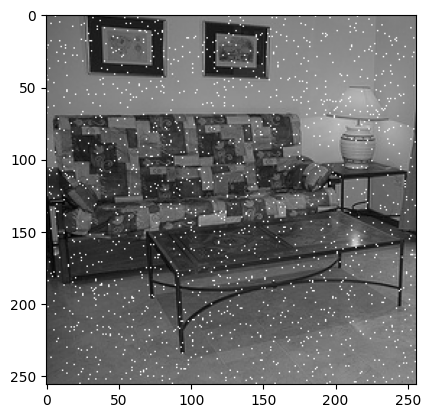

In [13]:
# Add Gaussian noise

noisy_patch = add_gaussian_noise(np.array(patch), seed=SEED)
plt.imshow(noisy_patch, cmap='gray')

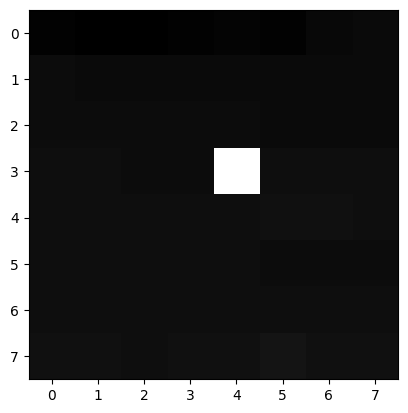

In [14]:
# Extract patches from the image

extracted_patches=extract_all_centered_patches(noisy_patch, PATCH_SIZE, PATCH_SIZE)
plt.imshow(extracted_patches[12345],cmap="grey")

In [15]:
# Extract similar patches

xi = (256 ** 2) / (PATCH_SIZE**2)  # TODO tuning
start_time = time.time()
similar_patches = block_matching_similar_patches_concurrent(extracted_patches, EXAMPLE_SIZE, EXAMPLE_SIZE, xi, 64)
end_time = time.time()
print(f"Execution Time (xi=128^2): {end_time - start_time:.2f} seconds")
print(similar_patches[22000].size / PATCH_SIZE**2)

Execution Time (xi=128^2): 6.58 seconds
34.0


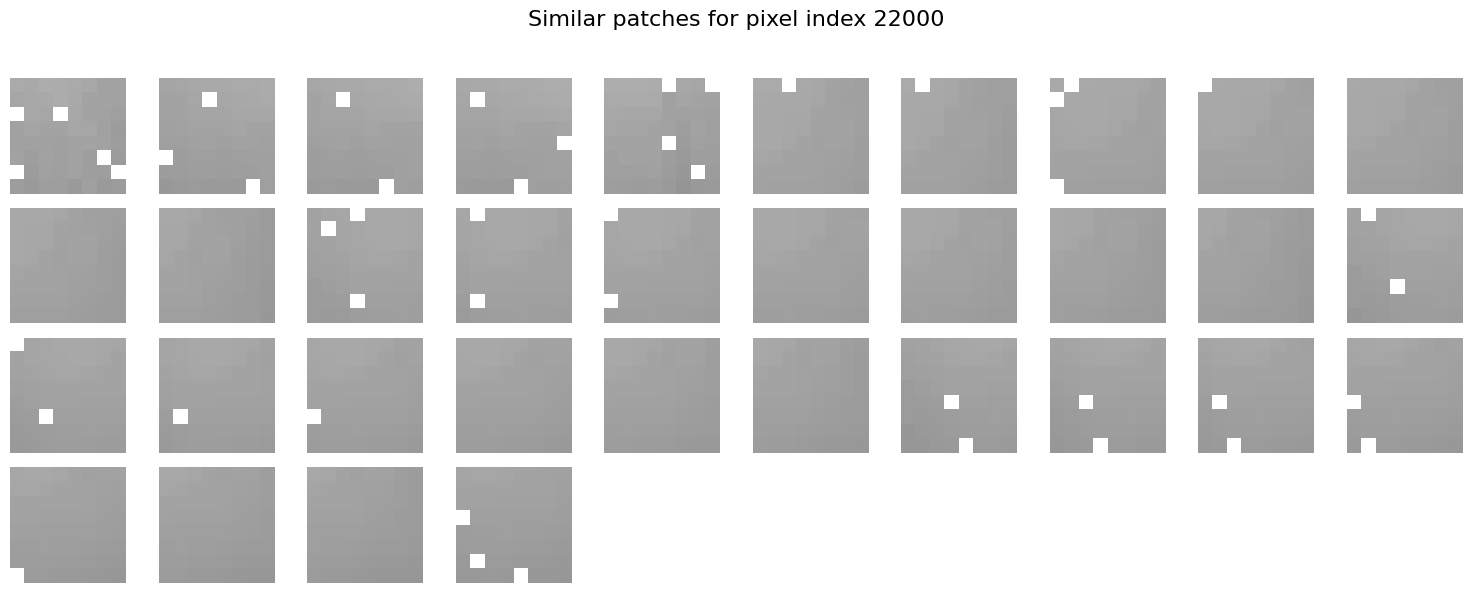

[[  5   3   5   3   1 253 248 247]
 [  3   4   3 173   2 251 250 248]
 [ 93   5   1  90   3 253 251 248]
 [  0   3   0   1   3   1 253 249]
 [  2   2   0 254   2   1   0 252]
 [163   1   3   0   5 255  95 251]
 [ 99 255   3   1   5   0   0  95]
 [  5   0   3   4   0   6 155 253]]


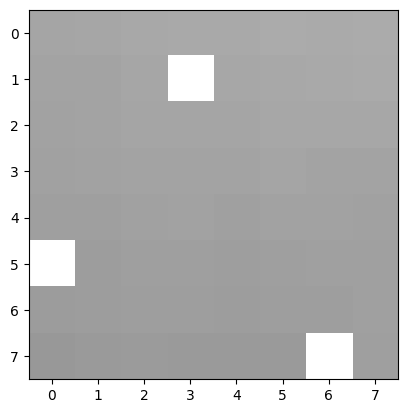

In [ ]:
# We can use this to check if the similar patches are actually similar, a occhio as we had few issues in the beginning with this

# When printing at a certain point we were checking the distance between patches we were values and did not see any difference. In order to change view them, we added the vmax/vim parameter to have a baselinef rom which to start and not set the largest/smaller values in the patch as baselines

display_patch_sets(similar_patches, 22000, PATCH_SIZE, PATCH_SIZE)
print(similar_patches[22000][0]-similar_patches[22000][1])
plt.imshow(similar_patches[22000][1],cmap="grey",vmin=0,vmax=255)

As of right now, this is what we have:
- `noisy_image`: the image on which we are learning the A coefficients as a numpy array
- `extracted_patches`: list of all patches
- `similar_patches`: list that, for each pixels, contains a numpy array of patches, each one being a numpy matrix of size PxP
- `model`: initial learned dictionary on a training dataset, of which `model.components_` has the actual data

In [17]:
print(extracted_patches.shape)
print(len(similar_patches))
print(model.components_)

(65536, 8, 8)
65536
[[ 0.01850193  0.10152991  0.14573363 ...  0.14704973  0.20474171
   0.16863869]
 [ 0.20450289  0.24326048  0.25100227 ...  0.14676436  0.12225232
   0.11259579]
 [ 0.08720661  0.07044824  0.08465991 ...  0.20714991  0.14213068
   0.05949619]
 ...
 [ 0.37846667  0.31446476  0.09373005 ...  0.02510309  0.05581186
  -0.00237831]
 [ 0.18380026  0.18879017  0.11579275 ...  0.05418858  0.08548713
   0.15902683]
 [ 0.13584799  0.14539624  0.15637305 ...  0.10288578  0.09494929
   0.12132087]]


In [18]:
# Let's compute my coefficients
# A = optimize_equation_8_batch(extracted_patches, model.components_, similar_patches)

In [19]:
# # Finally, let's use D and A to reconstruct the image
# reconstructed = reconstruct_image(A, model.components_, similar_patches, (noisy_patch.shape[0], noisy_patch.shape[1]), 8)
# 
# # Normalize the reconstructed image (if needed)
# reconstructed_display = reconstructed - reconstructed.min()  # Shift values to start from 0
# reconstructed_display /= reconstructed_display.max()  # Scale to [0, 1]
# 
# # Show image with grayscale colormap
# plt.imshow(reconstructed_display, cmap="gray")
# plt.axis("off")  # Hide axes for better visualization™i
# plt.show()


In [20]:
import numpy as np

def soft_thresholding(x, threshold):
    """Applies soft-thresholding element-wise."""
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def ista(Y, D, lambda_, L, num_iters=50):
    """
    Solves min_A Y - DA^2_F + lambda ||A||_1 using ISTA.

    Parameters:
    - Y: (P^2 x l) Matrix of vectorized similar patches.
    - D: (P^2 x k) Dictionary.
    - lambda_: Regularization parameter for sparsity.
    - L: Step size (largest eigenvalue of D^T D).
    - num_iters: Number of ISTA iterations.

    Returns:
    - A: (k x l) Sparse coefficients for all patches.
    """
    k, l = D.shape[1], Y.shape[1]  # Number of dictionary atoms and patches
    A = np.zeros((k, l))  # Initialize sparse codes

    DtD = D.T @ D  # Precompute D^T D
    DtY = D.T @ Y  # Precompute D^T Y
    step_size = 1.0 / L

    for _ in range(num_iters):
        A = soft_thresholding(A - step_size * (DtD @ A - DtY), lambda_ * step_size)

    return A

def solve_nonlocal_sparse_coding(similar_patches, model, lambda_=0.1, num_iters=50):
    """
    Solves equation (8) using ISTA for simultaneous sparse coding.

    Parameters:
    - noisy_image: The noisy image as a numpy array.
    - extracted_patches: List of all patches.
    - similar_patches: List where each entry contains similar patches.
    - model: Pre-trained dictionary (model.components_).
    - lambda_: Sparsity regularization parameter.
    - num_iters: Number of ISTA iterations.

    Returns:
    - A: (k x l) NumPy array of sparse coefficients for all patches.
    - D: Dictionary used for reconstruction.
    """
    D = model.components_.T  # Dictionary shape (P^2, k)

    total_patches = len(similar_patches)
    k = D.shape[1]  # Number of dictionary atoms

    # Initialize the full sparse coefficient matrix A
    A = np.zeros((k, total_patches))

    for i in range(total_patches):
        patch_group = similar_patches[i]
        if len(patch_group) == 0:
            continue
        
        # Stack similar patches into matrix Y (each column is a vectorized patch)
        Y = np.array(patch_group).reshape(len(patch_group), -1).T  # (P^2, l)
        L = np.linalg.norm(D.T @ D, 2)  # Step size (largest eigenvalue)

        # Compute sparse codes for group using ISTA
        A[:, i] = ista(Y, D, lambda_, L, num_iters).mean(axis=1)  # Average over group

    return A# Return as NumPy array

B = solve_nonlocal_sparse_coding(similar_patches, model)

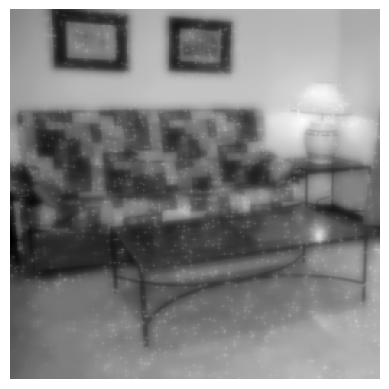

In [21]:
# Finally, let's use D and A to reconstruct the image
reconstructed = reconstruct_image(B, model.components_, similar_patches, (noisy_patch.shape[0], noisy_patch.shape[1]), 8)

# Normalize the reconstructed image (if needed)
reconstructed_display = reconstructed - reconstructed.min()  # Shift values to start from 0
reconstructed_display /= reconstructed_display.max()  # Scale to [0, 1]

# Show image with grayscale colormap
plt.imshow(reconstructed_display, cmap="gray")
plt.axis("off")  # Hide axes for better visualization™i
plt.show()


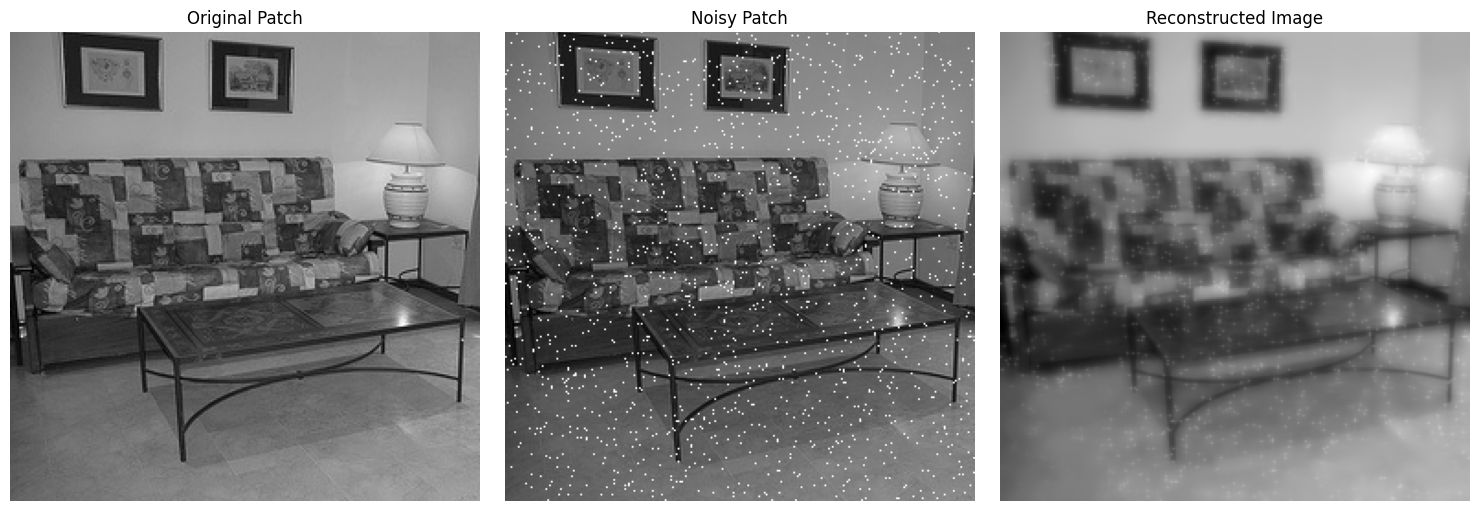

In [22]:
# Plot the original patch, noisy patch, and reconstructed image side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original patch
axes[0].imshow(patch, cmap='gray')
axes[0].set_title('Original Patch')
axes[0].axis('off')

# Noisy patch
axes[1].imshow(noisy_patch, cmap='gray')
axes[1].set_title('Noisy Patch')
axes[1].axis('off')

# Reconstructed image
axes[2].imshow(reconstructed_display, cmap='gray')
axes[2].set_title('Reconstructed Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()